This notebook demonstrates correlations between the legitimacy of candidates and the RB scores of their candidates $\textbf{IT DOESN'T SEEM TO BE WORKING YET}$

For S.3.7, let's start with the R/B. Three histograms (in a row, g-r-i) of the R/B scores for all sources detected (ever) in COSMOS and ELAIS. Then in the row below, perhaps histograms of the average R/B scores for all candidates with at least 3 detections in a given filter in one night (i.e., likely reals). This will give us an immediate comparison of R/B values for "all detections" and "all real candidates".

In [1]:
import psycopg2
import psycopg2.extras
import getpass
from IPython.display import display
import ipywidgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl

In [2]:
dbuser = input("DB User: ")
dbpasswd = getpass.getpass("DB Password: ")

DB User:  kennedyt
DB Password:  ············


In [3]:
db = psycopg2.connect(f"dbname='decat' user='{dbuser}' password='{dbpasswd}' host='decatdb.lbl.gov'")

In [4]:
db.autocommit = True # Makes the computer nicer about SQL syntax errors

cursor = db.cursor( cursor_factory = psycopg2.extras.DictCursor )

In [5]:
font = {'size'   : 15}

mpl.rc('font', **font)

### Top Panel

In [6]:
# Pulling in all the detctions ever from both COSMOS and ELIAS
query = ( 'SELECT o.id, o.rb, o.candidate_id, e.filter, e.mjd, e.filename FROM objects o '
         'JOIN subtractions s ON o.subtraction_id=s.id '
         'JOIN exposures e ON e.id=s.exposure_id '
         'WHERE q3c_radial_query(o.ra,o.dec,150,2.2,3) '
         'LIMIT 10000000' )

cursor.execute( query )

COSMOSrbquery = np.array( cursor.fetchall() ).transpose()

query = ( 'SELECT o.id, o.rb, o.candidate_id, e.filter, e.mjd, e.filename FROM objects o '
         'JOIN subtractions s ON o.subtraction_id=s.id '
         'JOIN exposures e ON s.exposure_id=e.id '
         'WHERE q3c_radial_query(o.ra,o.dec,8.5,-43.5,2) '
         'LIMIT 10000000' )

cursor.execute( query )

ELIASrbquery = np.array( cursor.fetchall() ).transpose()

In [7]:
# Eliminating dupes (COSMOS)
C_dupes = np.array([COSMOSrbquery[1],COSMOSrbquery[2],COSMOSrbquery[3],COSMOSrbquery[4],COSMOSrbquery[5]]).transpose()
C_dupes = np.array([" ".join(i) for i in C_dupes])
unique, ind = np.unique(C_dupes, return_index=True)
uarr = np.array( [ i.split(" ") for i in unique ] ).transpose()
Cres = np.array( [COSMOSrbquery[0][ind], uarr[0], uarr[1], uarr[2], uarr[3], uarr[4]] )

# Eliminating dupes (ELIAS)
E_dupes = np.array([ELIASrbquery[1],ELIASrbquery[2],ELIASrbquery[3],ELIASrbquery[4],ELIASrbquery[5]]).transpose()
E_dupes = np.array([" ".join(i) for i in E_dupes])
unique, ind = np.unique(E_dupes, return_index=True)
uarr = np.array( [ i.split(" ") for i in unique ] ).transpose()
Eres = np.array( [ELIASrbquery[0][ind], uarr[0], uarr[1], uarr[2], uarr[3], uarr[4]] )

In [8]:
# read in the exposure time lookup table
lutable = np.loadtxt("archive_image_list.txt", dtype=object).transpose()
fnmtable, exptable = lutable[0], lutable[7].astype(float)


# truncate filenames to match lookup table format (COSMOS)
Cfnms = [ Cres[5][i][:21] for i in range( len( Cres[5] ) ) ]
# find the exposure time for each object
Cexptimes = np.array([exptable[np.where(Cfnms[i] == fnmtable)[0]][0] for i in range(len(Cfnms))], dtype=float)

# truncate filenames to match lookup table format (ELIAS)
Efnms = [ Eres[5][i][:21] for i in range( len( Eres[5] ) ) ]
# find the exposure time for each object
Eexptimes = np.array([exptable[np.where(Efnms[i] == fnmtable)[0]][0] for i in range(len(Efnms))], dtype=float)

In [9]:
# Eliminate nonstandard exposure times (COSMOS)
Cfilters = Cres[3]
gmsk = np.where((Cfilters=="g") & (Cexptimes>50))[0]
rmsk = np.where((Cfilters=="r") & (Cexptimes>20))[0]
imsk = np.where((Cfilters=="i") & (Cexptimes>20))[0]

grmsk = np.append(rmsk, gmsk)
Cgrimsk = np.append(grmsk, imsk)
Cres = [i[Cgrimsk] for i in Cres]

# Eliminate nonstandard exposure times (ELIAS)
Efilters = Eres[3]
gmsk = np.where((Efilters=="g") & (Eexptimes>50))[0]
rmsk = np.where((Efilters=="r") & (Eexptimes>20))[0]
imsk = np.where((Efilters=="i") & (Eexptimes>20))[0]

grmsk = np.append(rmsk, gmsk)
Egrimsk = np.append(grmsk, imsk)
Eres = [i[Egrimsk] for i in Eres]

In [10]:
Cgmsk = np.where(Cres[3] == "g")[0]
Crmsk = np.where(Cres[3] == "r")[0]
Cimsk = np.where(Cres[3] == "i")[0]
opic = [Cres[1][Cgmsk].astype(float),
        Cres[1][Crmsk].astype(float),
        Cres[1][Cimsk].astype(float)]
Egmsk = np.where(Eres[3] == "g")[0]
Ermsk = np.where(Eres[3] == "r")[0]
Eimsk = np.where(Eres[3] == "i")[0]
opie = [Eres[1][Egmsk].astype(float),
        Eres[1][Ermsk].astype(float),
        Eres[1][Eimsk].astype(float)]

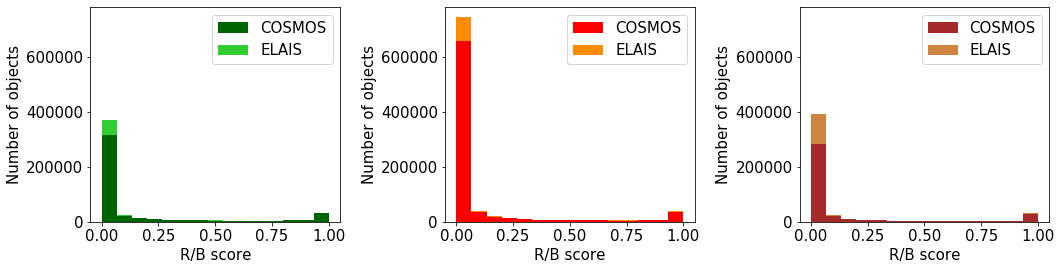

In [11]:
c = ['darkgreen', 'red', 'brown', 'limegreen', 'darkorange', 'peru']
bins = np.histogram(opic[0], bins=15)[1]
fig, ax = plt.subplots( 1,3,figsize=(15,4), sharey=True )

for i in [0,1,2]:
    ax[i].yaxis.set_tick_params(which='both', labelbottom=True)
    ax[i].hist( [opic[i],opie[i]], bins, stacked=True, color=[c[i],c[i+3]], label=['COSMOS','ELAIS'])
    ax[i].legend()
    ax[i].set_ylabel("Number of objects")
    ax[i].set_xlabel("R/B score")
fig.tight_layout()
plt.savefig("./images/RBvobjsCOSMOS.png")

### Bottom Panel

In [12]:
x = []
for f in [Cgmsk, Crmsk, Cimsk]:
    # Select the nights, candidates, and a list of unique candidates in a certain filter
    Crnights = np.round( Cres[4][f].astype(float) )
    Ccands = Cres[2][f]
    Cucands = np.unique(Cres[2][f])
    # Get a list of every observing night
    unights = np.unique(Crnights)

    # Make a list of every candidate (including repeats) detected in each night
    arr = [ Ccands[ Crnights == i ] for i in unights ]

    # Create arrays 
    newarr = [ np.array( np.unique( i, return_index=True, return_counts = True) ) for i in arr ]
    cands = [i[0] for i in newarr]
    indices = [i[1] for i in newarr]
    cts = [i[2] for i in newarr]

    newnewarr = [ cands[i][ np.where(cts[i].astype(int) > 3)[0] ] for i in range(len(newarr)) ]
    print(newnewarr[0])
    for i in newnewarr:
        x.extend(i)
goodcands = np.unique(x)

['DC21ba' 'DC21bam' 'DC21bao' 'DC21bap' 'DC21bbc' 'DC21bbe' 'DC21bby'
 'DC21bc' 'DC21bcd' 'DC21bce' 'DC21bcn' 'DC21bdu' 'DC21bdw' 'DC21bdx'
 'DC21beh' 'DC21bf' 'DC21bfq' 'DC21bfr' 'DC21bfs' 'DC21bfy' 'DC21bg'
 'DC21bgl' 'DC21bgt' 'DC21bhk' 'DC21bhw' 'DC21bic' 'DC21bil' 'DC21bj'
 'DC21bje' 'DC21bjy' 'DC21bkf' 'DC21bkj' 'DC21blg' 'DC21bma' 'DC21bmd'
 'DC21bmx' 'DC21bne' 'DC21bnt' 'DC21boc' 'DC21bog' 'DC21boj' 'DC21bor'
 'DC21bou' 'DC21bp' 'DC21bqj' 'DC21bqn' 'DC21bqo' 'DC21br' 'DC21bsa'
 'DC21bsv' 'DC21bt' 'DC21btr' 'DC21but' 'DC21bv' 'DC21bvc' 'DC21bvf'
 'DC21bvt' 'DC21bxb' 'DC21bxv' 'DC21by' 'DC21bzj' 'DC21bzn' 'DC21bzu'
 'DC21bzv' 'DC21cav' 'DC21cbm' 'DC21ccg' 'DC21ccr' 'DC21cda' 'DC21cfc'
 'DC21cgy' 'DC21che' 'DC21chg' 'DC21chi' 'DC21chk' 'DC21ci' 'DC21cja'
 'DC21cjv' 'DC21cjy' 'DC21ck' 'DC21ckb' 'DC21ckc' 'DC21cl' 'DC21cla'
 'DC21clc' 'DC21clw' 'DC21cm' 'DC21cmk' 'DC21cns' 'DC21cny' 'DC21co'
 'DC21cpc' 'DC21cpj' 'DC21cqh' 'DC21crg' 'DC21crk' 'DC21csj' 'DC21cst'
 'DC21csz' 'DC21ctu' 

In [13]:
len(goodcands)

14052

(array([365730.,  19991.,  11442.,   8265.,   6677.,   5829.,   5390.,
          5387.,   6127.,  77967.]),
 array([0.        , 0.09999991, 0.19999982, 0.29999973, 0.39999964,
        0.49999954, 0.59999945, 0.69999936, 0.79999927, 0.89999918,
        0.99999909]),
 <a list of 10 Patch objects>)

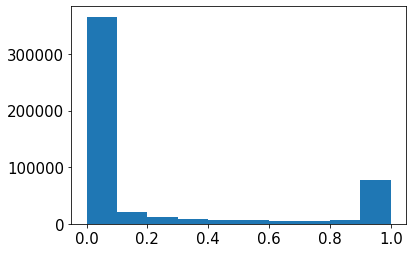

In [14]:
msk = np.isin(COSMOSrbquery[2], goodcands, invert=True)
plt.hist(COSMOSrbquery[1][msk].astype(float))

(array([1049302.,   59410.,   30955.,   21210.,   16222.,   13588.,
          12214.,   12047.,   13806.,   33545.]),
 array([0.        , 0.09999984, 0.19999968, 0.29999952, 0.39999937,
        0.49999921, 0.59999905, 0.69999889, 0.79999873, 0.89999857,
        0.99999841]),
 <a list of 10 Patch objects>)

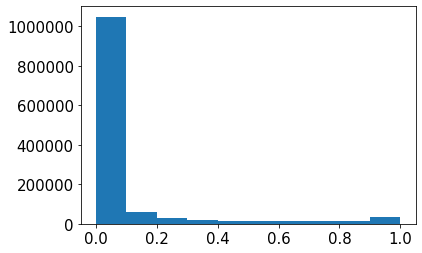

In [15]:
msk = np.isin(COSMOSrbquery[2], goodcands, invert=False)
plt.hist(COSMOSrbquery[1][msk].astype(float))

In [16]:
sum(msk.astype(int))

1262299

In [17]:
"DC21dqik" in goodcands

True

In [18]:
g = ['DC21bcpi', 'DC21bicq', 'DC21bkrj', 'DC21bpls', 'DC21cove',
       'DC21cxou', 'DC21dhgr', 'DC21dqf', 'DC21dqik', 'DC21dtwb',
       'DC21eqq', 'DC21fber', 'DC21homb', 'DC21hunj', 'DC21ixp',
       'DC21kgy', 'DC21kog', 'DC21ktp', 'DC21kxb', 'DC21url']

In [19]:
for i in g:
    print(i in goodcands)
[i for i in g if i not in goodcands]

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


[]